In [1]:
import os
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline

print(tf.__version__)

2.2.0


# Parameter setting

In [2]:
IMAGE_SIZE = [[512, 352], [512, 384], [448, 448], [384, 512], [352, 512]]
IMAGE_RATIO = [1.4545454545454546, 1.3333333333333333, 1.0, 0.75, 0.6875]
EMBEDDING_SIZE = 512

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# TPU

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Dataset

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

train_info = pd.read_csv("../input/landmark-retrieval-2020/train.csv")

prefix = '../input/landmark-retrieval-2020/train/'
train_info['file_path'] = train_info['id'].apply(lambda x:prefix+ x[0]+'/'+x[1]+'/'+x[2]+'/'+x+".jpg")

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True)

train_info['label'] = label_encoder.fit_transform(train_info['landmark_id'].values)
train_info['one_hot'] = one_hot_encoder.fit_transform(
                    train_info['label'].values.reshape(-1, 1))

num_train_samples = len(train_info)
print(num_train_samples)
num_train_labels = train_info['label'].nunique()
print(num_train_labels)

3147
2916


# Sample visualization

(799, 590, 3)

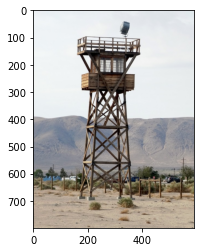

In [5]:
testimg = cv2.cvtColor(cv2.imread(np.random.choice(train_info['file_path'])), cv2.COLOR_BGR2RGB)
plt.imshow(testimg)
testimg.shape

In [6]:
class Landmark2020_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    
                    iaa.Affine(rotate=0),
                    #iaa.Affine(rotate=90),
                    #iaa.Affine(rotate=180),
                    #iaa.Affine(rotate=270),
                    iaa.Fliplr(0.5),
                    #iaa.Flipud(0.5),
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image_norm = skimage.io.imread(path)/255.0
        

        im = resize(image_norm, (shape[0], shape[1],shape[2]), mode='reflect')
        return im

# Model setting

## Embedding Model
- EfficientNet B7
- Generalized mean pooling

In [7]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

from tensorflow.keras.layers import Layer, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K
import tensorflow_probability as tfp


class AdaCos(Layer):
    def __init__(self, n_classes=10, regularizer=None, **kwargs):
        super(AdaCos, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = math.sqrt(2)*math.log(n_classes-1)
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(AdaCos, self).build(input_shape)
        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        # normalize feature
        x = tf.nn.l2_normalize(inputs, axis=1, name='norm_embeddings')
        print(x)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0, name='norm_loss_weights')
        print(y)
        # dot product
        logits = x @ W
        
        return logits
    
    def get_logits(self, y_true, y_pred):
        logits = y_pred
        
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))

        B_avg = tf.where(y < 1, tf.exp(self.s*logits), tf.zeros_like(logits))
        B_avg = tf.reduce_mean(tf.reduce_sum(B_avg, axis=1), name='B_avg')
        theta_class = tf.gather(theta, tf.cast(y, tf.int32), name='theta_class')
        theta_med = tfp.stats.percentile(theta_class, q=50)

        with tf.control_dependencies([theta_med, B_avg]):
            self.s = tf.math.log(B_avg) / tf.cos(tf.minimum(math.pi/4, theta_med))
            logits = self.s * logits
        return logits

    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.nn.categorical_crossentropy(labels=labels, logits=logits, from_logits=True)
        return loss

    def accuracy(self, y_true, y_pred):
        logits = self.get_logits(labels, y_pred)
        accuracy = tf.keras.metrics.categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_classes)


class Generalized_mean_pooling2D(Layer):
    def __init__(self, p=3, epsilon=1e-6, **kwargs):
        super(Generalized_mean_pooling2D, self).__init__(**kwargs)

        self.init_p = p
        self.epsilon = epsilon

    def build(self, input_shape):
        if isinstance(input_shape, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')

        self.build_shape = input_shape

        self.p = self.add_weight(
              name='p',
              shape=[1,],
              initializer=tf.keras.initializers.Constant(value=self.init_p),
              regularizer=None,
              trainable=True,
              dtype=tf.float32
              )

        self.built=True

    def call(self, inputs):
        input_shape = inputs.get_shape()
        if isinstance(inputs, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')

        return (tf.reduce_mean(tf.abs(inputs**self.p), axis=[1,2], keepdims=False) + self.epsilon)**(1.0/self.p)

with strategy.scope():
    enet = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False
    )
    enet.trainable = True

    embed_model = tf.keras.Sequential([
        enet,
        Generalized_mean_pooling2D(name='GeM'),
        Dense(EMBEDDING_SIZE, activation='softmax', name='fc'),
        BatchNormalization(name='batchnorm')

    ])
    adacos_model = AdaCos(num_train_labels)(embed_model.output)
    
    entire_model = Model(inputs=embed_model.input, outputs=adacos_model.output)
    
entire_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss = adacos_model.loss,  
              metrics=[adacos_model.accuracy])

entire_model.summary()

Tensor("ada_cos/norm_embeddings:0", shape=(None, 512), dtype=float32)


NameError: in user code:

    <ipython-input-7-87fc4bd844a4>:33 call  *
        print(y)

    NameError: name 'y' is not defined


In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.8], [50, 49, 0]])
m.result().numpy()